# Obtendo dados

In [5]:
from bs4 import BeautifulSoup
import requests
import tarfile
import urllib.request
import os

In [6]:
DOWNLOAD_ROOT = "https://spamassassin.apache.org/old/publiccorpus/"
DATA_PATH = os.path.join("datasets", "spamassassin")

In [59]:
html = requests.get(DOWNLOAD_ROOT).text
soup = BeautifulSoup(html, 'html5lib')
urls = [href for href in [link.get('href') for link in soup.find_all('a')] if href[-4:] == '.bz2']

for url in urls:
    full_url = DOWNLOAD_ROOT + url
    os.makedirs(DATA_PATH, exist_ok=True)
    tgz_path = os.path.join(DATA_PATH, url)
    urllib.request.urlretrieve(full_url, tgz_path)

    with tarfile.open(tgz_path) as spam_tgz:
        spam_tgz.extractall(path=DATA_PATH)

# Carregando dados

In [9]:
from glob import glob
import numpy as np
import pandas as pd

In [13]:
def read_file(file_url):
    with open(file_url, "rb") as file:
        text = file.read()
    
    try:
        return text.decode('utf-8', 'strict')
    except:
        return ''

In [14]:
df = pd.Series(
    glob(DATA_PATH + "\\*\\*")
).apply(lambda file_url: pd.Series([read_file(file_url), "ham" not in file_url], index=['text','result']))

# Limpando os dados

In [17]:
df = df[df.text.str.match('.')]

In [24]:
X, y = df.values.T

In [58]:
y = y.astype('i')

# Dividindo treino e teste

In [27]:
from sklearn.model_selection import train_test_split

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42, shuffle=True, stratify=y)

# Criando modelo

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

import re

In [60]:
body_regex = re.compile('(.*?:| {2,}[^|]|\t).*?\n')
subject_regex = re.compile(r'(?i)Subject: ?(.*?)\n')

In [61]:
class Select_Part(BaseEstimator):
    def __init__(self, part = 'all'): # no *args or **kwargs
        self.part = part
        
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, X, y=None):
        if self.part == 'all':
            return X
        elif self.part == 'body':
            return [re.sub(body_regex, '', x) for x in X]
        else:
            raise ValueError("Use only 'all' or 'body")

In [62]:
clf = Pipeline([
    ('selector', Select_Part()),
    ('vectorizer', TfidfVectorizer()),
    ('classifier', SGDClassifier(random_state=42))
])

In [63]:
clf.fit(X_train, y_train)

Pipeline(steps=[('selector', Select_Part()), ('vectorizer', TfidfVectorizer()),
                ('classifier', SGDClassifier(random_state=42))])

In [64]:
from sklearn.model_selection import cross_val_score
cross_val_score(clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.98997384, 0.99040558, 0.99345835])

In [65]:
clf.score(X_test, y_test)

0.9947704822777454

In [67]:
param_grid = [
    {
        "selector__part": ['all', 'body'],
        "vectorizer__binary": [True],
        "vectorizer__use_idf": [True, False],
        "vectorizer__sublinear_tf": [False],
    },
    
    {
        "selector__part": ['all', 'body'],
        "vectorizer__binary": [False],
        "vectorizer__use_idf": [True, False],
        "vectorizer__sublinear_tf": [True, False],
    },
]

In [68]:
grid_search = GridSearchCV(clf, param_grid,scoring='accuracy')

In [69]:
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('selector', Select_Part()),
                                       ('vectorizer', TfidfVectorizer()),
                                       ('classifier',
                                        SGDClassifier(random_state=42))]),
             param_grid=[{'selector__part': ['all', 'body'],
                          'vectorizer__binary': [True],
                          'vectorizer__sublinear_tf': [False],
                          'vectorizer__use_idf': [True, False]},
                         {'selector__part': ['all', 'body'],
                          'vectorizer__binary': [False],
                          'vectorizer__sublinear_tf': [True, False],
                          'vectorizer__use_idf': [True, False]}],
             scoring='accuracy')

In [70]:
cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=3, scoring='accuracy')

array([0.9956408 , 0.99520279, 0.99607501])

# Resultados

In [74]:
from sklearn.metrics import RocCurveDisplay, roc_auc_score

In [71]:
grid_search.best_estimator_.score(X_test, y_test)

0.9982568274259151

In [72]:
grid_search.best_params_

{'selector__part': 'all',
 'vectorizer__binary': True,
 'vectorizer__sublinear_tf': False,
 'vectorizer__use_idf': True}

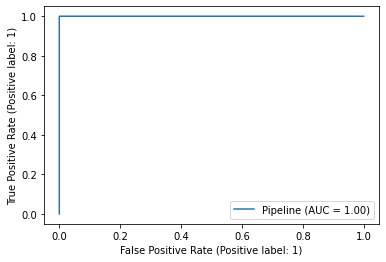

In [75]:
RocCurveDisplay.from_estimator(grid_search.best_estimator_, X_test, y_test, response_method='decision_function')